In [1]:
using StockFlow

using Catlab
using Catlab.CategoricalAlgebra
using LabelledArrays
using OrdinaryDiffEq
using Plots

using Catlab.Graphics
using Catlab.Programs
using Catlab.WiringDiagrams

In [2]:
Graph = StockFlow.Graph

Catlab.Graphics.Graphviz.Graph

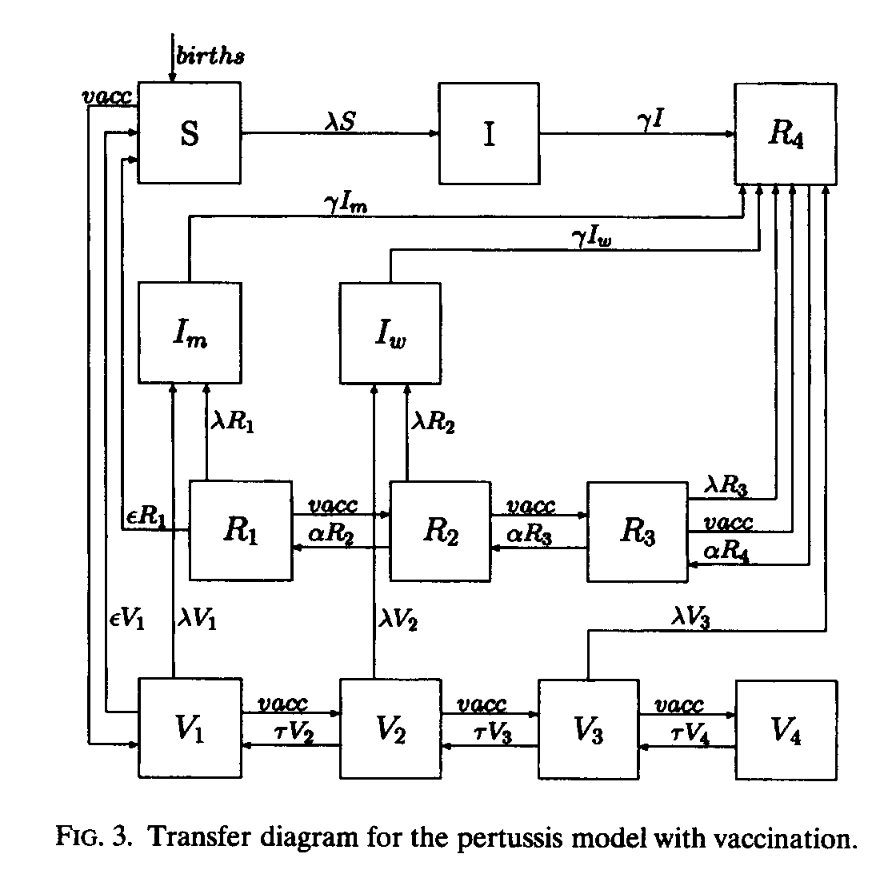
cite from paper: Hethcote, Herbert W. "An age-structured model for pertussis transmission." Mathematical biosciences 145.2 (1997): 89-136.

In [3]:
# define the function of new born
fNewBorn(u,uN,p,t)=uN.N(u,t)*p.rBirth
# define other functions of flows in this model, since all the other flows' functions have the 
# same form: up_stream stock * rate
# uS: name (symbol) of the upper stream stock
# r: name (symbol) of the parameter rate
function fLinear(uS,r)
    fL(u,uN,p,t) = u[uS]*p[r]
    return fL
end
# define the functions of new infectious flow
function fInfectious(uS)
    fI(u,uN,p,t) = u[uS]*p[:β]*uN.NI(u,t)/uN.N(u,t)
    return fI
end

fInfectious (generic function with 1 method)

In [4]:
# define function of concatenate of two strings to symbol
# s1,s2: String
fsymbol(s1,s2)=Symbol(s1*s2)

fsymbol (generic function with 1 method)

# 1. Define the components of all the sub-models

## 1.1 Define open sub-model including each stock and its death flow

In [5]:
#(stock_name=>(inflows, outflows, variables, svariables))
     ## if a stock has no inflow or no outflow, use keyword ":F_NONE"
     ## if a stock has no variables connect to, use keyword ":V_NONE"
     ## if a stock has no sum_variables connect to, use keyword ":SV_NONE"
#(flow=>variable)
#(variable=>function)
#(svariable=>variable)
     ## if sum_variable contributes to no variables, use keywork ":SVV_NONE"

# function to create a open stock and flow diagram of diagnosis
# s: string of the stock name
fOpenDeaths(s) = Open(
    # stock and flow diagram
    StockAndFlow(
    #stocks
    (Symbol(s)=>(:F_NONE,fsymbol("Deaths_",s),fsymbol("v_Deaths_",s),:N)),    
    #flows
    (fsymbol("Deaths_",s)=>fsymbol("v_Deaths_",s)),           
    #dynamical variables
    (fsymbol("v_Deaths_",s)=>fLinear(Symbol(s),:rDeath)),    
    #sum dynamical variables
    (:N=>:SVV_NONE)
    ),
    # feet
    foot(Symbol(s),:N,Symbol(s)=>:N)
)

fOpenDeaths (generic function with 1 method)

### For example, the deaths sub-model of stock "S" is:

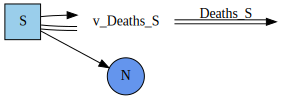

In [6]:
Graph(apex(fOpenDeaths("S")))

## 1.2 Define the SIR sub-model including the flow of new borns to stock S

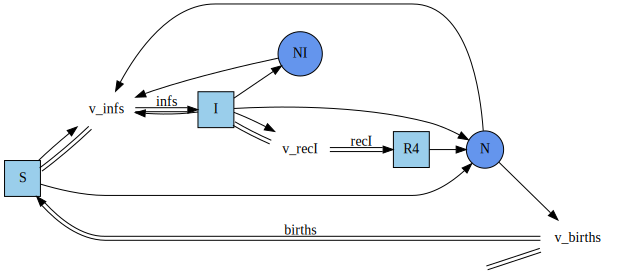

In [7]:
openSIR=Open(
    StockAndFlow(
    (:S=>(:births,:infs,:v_infs,:N), 
        :I=>(:infs,:recI,(:v_infs, :v_recI),(:N,:NI)),
        :R4=>(:recI,:F_NONE,:V_NONE,:N)),
    (:births=>:v_births,:infs=>:v_infs,:recI=>:v_recI),
    (:v_births=>fNewBorn,:v_infs=>fInfectious(:S),:v_recI=>fLinear(:I,:γ)),
    (:N=>(:v_births,:v_infs),:NI=>:v_infs)
    ),
    # feet
    foot(:S,:N,:S=>:N),
    foot(:I,:N,:I=>:N),
    foot(:R4,:N,:R4=>:N),
    foot((),:NI,())
)
Graph(apex(openSIR))

## 1.3 Define the open sub-model of VRIR, including V1R1ImR4 and V2R2IwR4

In [8]:
# n: string of "1" or "2"
# mw:string of "m" or "w"
openVRIR(n,mw)=Open(
    StockAndFlow(
    (fsymbol("V",n)=>(:F_NONE,fsymbol("infV",n),fsymbol("v_infV",n),:N), 
        fsymbol("R",n)=>(:F_NONE,fsymbol("infR",n),fsymbol("v_infR",n),:N),
        fsymbol("I",mw)=>((fsymbol("infV",n),fsymbol("infR",n)),fsymbol("recI",mw),fsymbol("v_recI",mw),(:N,:NI)),
        :R4=>(fsymbol("recI",mw),:F_NONE,:V_NONE,:N)),
    (fsymbol("infV",n)=>fsymbol("v_infV",n),fsymbol("infR",n)=>fsymbol("v_infR",n),fsymbol("recI",mw)=>fsymbol("v_recI",mw)),
    (fsymbol("v_infV",n)=>fInfectious(fsymbol("V",n)),fsymbol("v_infR",n)=>fInfectious(fsymbol("R",n)),fsymbol("v_recI",mw)=>fLinear(fsymbol("I",mw),:γ)),

        (:N=>(fsymbol("v_infV",n),fsymbol("v_infR",n)),:NI=>(fsymbol("v_infV",n),fsymbol("v_infR",n)))
    ),
    # feet
    foot(fsymbol("V",n),:N,fsymbol("V",n)=>:N),
    foot(fsymbol("I",mw),:N,fsymbol("I",mw)=>:N),
    foot(fsymbol("R",n),:N,fsymbol("R",n)=>:N),
    foot(:R4,:N,:R4=>:N),
    foot((),:NI,())
)

openVRIR (generic function with 1 method)

### For example, the V1R1ImR4 model is:

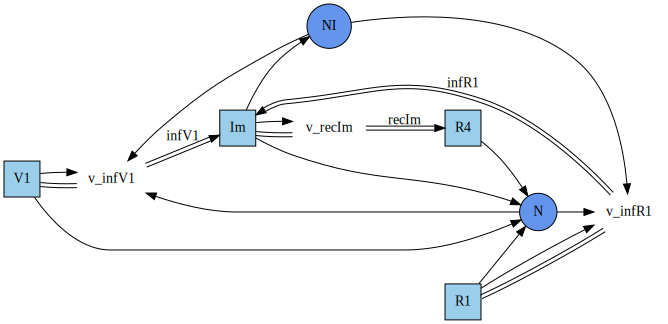

In [9]:
Graph(apex(openVRIR("1","m")))

## 1.4 Define the immunity increase and decrease between two levels of V or R

In [10]:
# us and ds: are the string of upstream and downstream stocks
# dr: the symbol of decreasing immunity rate
# Note, the increase immunity rate are always :vacc
fOpenImmunity(us,ds,r) = Open(
    # stock and flow diagram
    StockAndFlow(
    #stocks
    (Symbol(us)=>(fsymbol(ds,"WaningImmunity"),fsymbol("Vacc",us),fsymbol("v_Vacc",us),:N),
     Symbol(ds)=>(fsymbol("Vacc",us),fsymbol(ds,"WaningImmunity"),fsymbol("v_WanImmu",ds),:N)),    
    #flows
    (fsymbol(ds,"WaningImmunity")=>fsymbol("v_WanImmu",ds),
     fsymbol("Vacc",us)=>fsymbol("v_Vacc",us)),           
    #dynamical variables
    (fsymbol("v_WanImmu",ds)=>fLinear(Symbol(ds),r),
     fsymbol("v_Vacc",us)=>fLinear(Symbol(us),:vacc)),    
    #sum dynamical variables
    (:N=>:SVV_NONE)
    ),
    # feet
    foot(Symbol(us),:N,Symbol(us)=>:N),
    foot(Symbol(ds),:N,Symbol(ds)=>:N)
)

fOpenImmunity (generic function with 1 method)

### For example, the sub-model between R1 and R2 is:

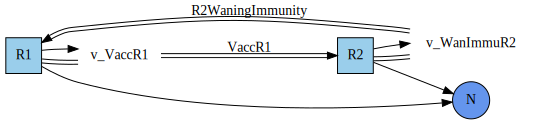

In [11]:
Graph(apex(fOpenImmunity("R1","R2",:α)))

## 1.5 The rest sub-model components
### 1.5.1 The rest sub-model components of new infectious
Including, the new infectious from stock R3 or V3 to R4 

In [12]:
# us: string of name of stock R3 or V3 
fOpenR3OrV3ToR4(s) = Open(
    # stock and flow diagram
    StockAndFlow(
    #stocks
    (Symbol(s)=>(:F_NONE,fsymbol("inf",s),fsymbol("v_inf",s),:N),
     :R4=>(fsymbol("inf",s),:F_NONE,:V_NONE,:N)),    
    #flows
    fsymbol("inf",s)=>fsymbol("v_inf",s),           
    #dynamical variables
    fsymbol("v_inf",s)=>fInfectious(Symbol(s)),  
    #sum dynamical variables
    (:N=>fsymbol("v_inf",s),:NI=>fsymbol("v_inf",s))
    ),
    # feet
    foot(Symbol(s),:N,Symbol(s)=>:N),
    foot(:R4,:N,:R4=>:N),
    foot((),:NI,())
)

fOpenR3OrV3ToR4 (generic function with 1 method)

### For example, sub-model of new infectious from Stock V3 to R4

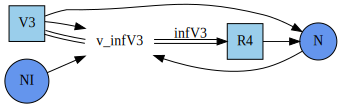

In [13]:
Graph(apex(fOpenR3OrV3ToR4("V3")))

### 1.5.2 The rest sub-model components of waning immunity from Stock R1 to S

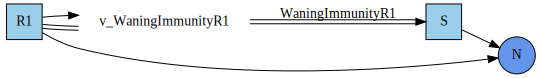

In [14]:
OpenR1ToS = Open(
    # stock and flow diagram
    StockAndFlow(
    #stocks
    (:R1=>(:F_NONE,:WaningImmunityR1,:v_WaningImmunityR1,:N),
     :S=>(:WaningImmunityR1,:F_NONE,:V_NONE,:N)),    
    #flows
    :WaningImmunityR1=>:v_WaningImmunityR1,           
    #dynamical variables
    :v_WaningImmunityR1=>fLinear(:R1,:ϵ),    
    #sum dynamical variables
    (:N=>:SVV_NONE)
    ),
    # feet
    foot(:R1,:N,:R1=>:N),
    foot(:S,:N,:S=>:N)
)
Graph(apex(OpenR1ToS))

# 2. Composition

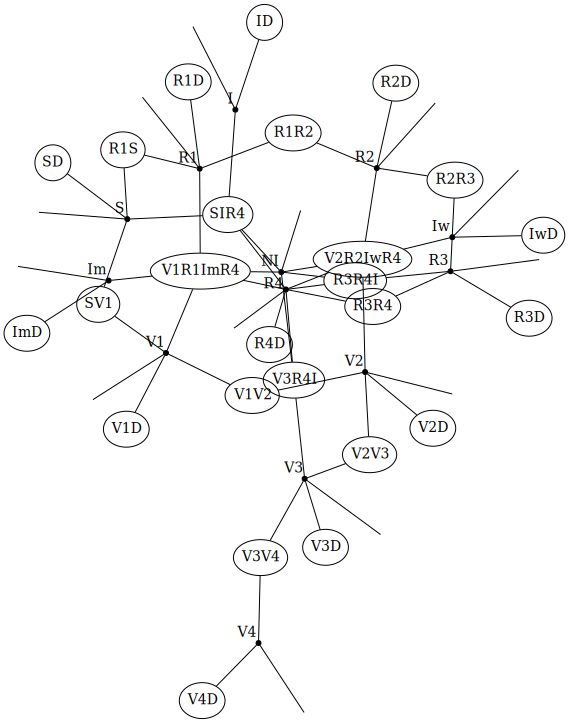

In [15]:
# define the UWD-algebra of Hyperglycemic Model
pertussis_uwd = @relation (S,I,Im,Iw,R1,R2,R3,R4,V1,V2,V3,V4,NI) begin
    SD(S)
    ID(I)
    ImD(Im)
    IwD(Iw)
    R1D(R1)
    R2D(R2)
    R3D(R3)
    R4D(R4)
    V1D(V1)
    V2D(V2)
    V3D(V3)
    V4D(V4)
    SIR4(S,I,R4,NI)
    V1R1ImR4(V1,Im,R1,R4,NI)
    V2R2IwR4(V2,Iw,R2,R4,NI)
    R1R2(R1,R2)
    R2R3(R2,R3)
    R3R4(R3,R4)
    SV1(S,V1)
    V1V2(V1,V2)
    V2V3(V2,V3)
    V3V4(V3,V4)
    V3R4I(V3,R4,NI)
    R3R4I(R3,R4,NI)
    R1S(R1,S)
end;
display_uwd(pertussis_uwd)

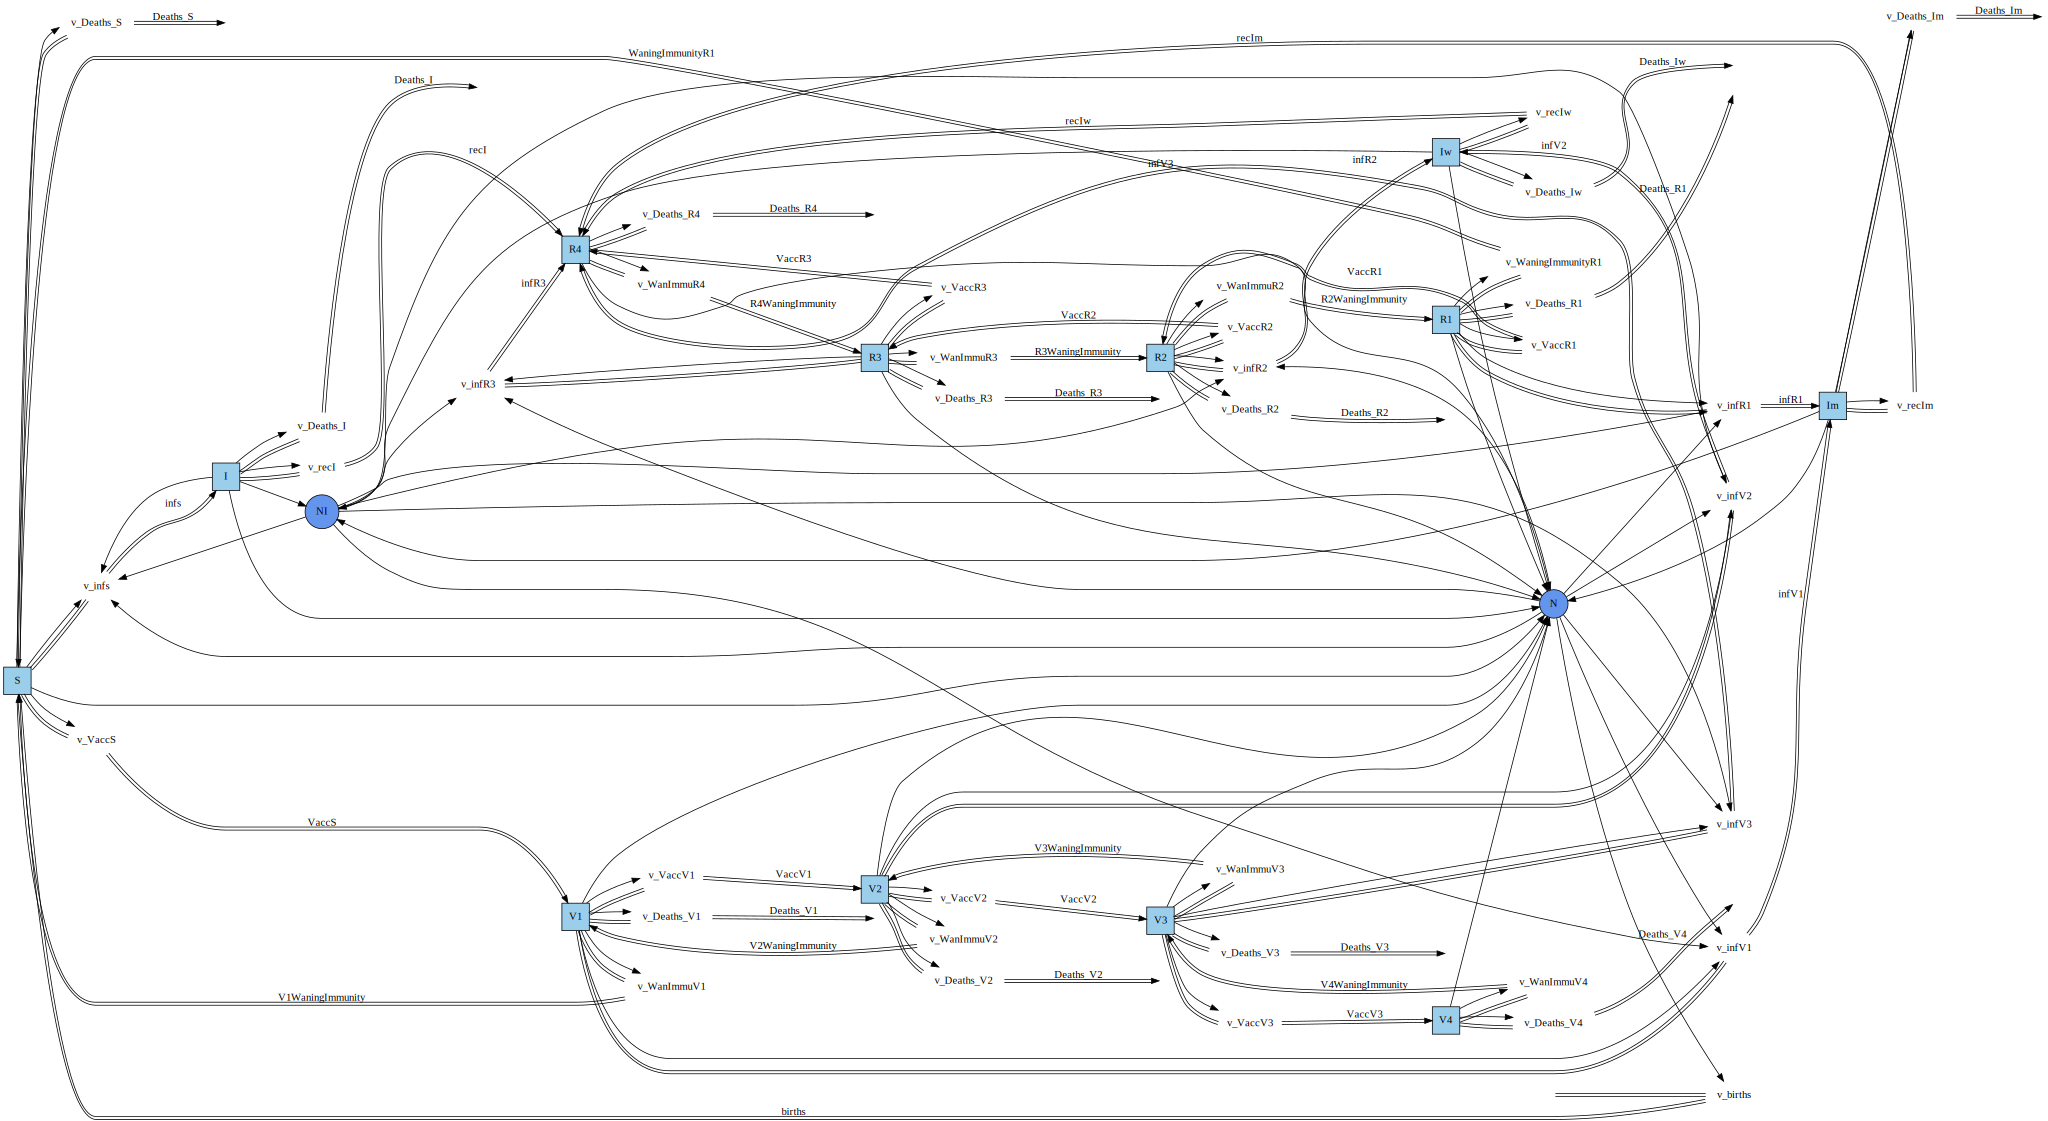

In [16]:
pertussis_model = oapply(pertussis_uwd,Dict(
    :SD=>fOpenDeaths("S"),
    :ID=>fOpenDeaths("I"),
    :ImD=>fOpenDeaths("Im"),
    :IwD=>fOpenDeaths("Iw"),
    :V1D=>fOpenDeaths("V1"),
    :V2D=>fOpenDeaths("V2"),
    :V3D=>fOpenDeaths("V3"),
    :V4D=>fOpenDeaths("V4"),
    :R1D=>fOpenDeaths("R1"),
    :R2D=>fOpenDeaths("R2"),
    :R3D=>fOpenDeaths("R3"),
    :R4D=>fOpenDeaths("R4"),
    :SIR4=>openSIR,
    :V1R1ImR4=>openVRIR("1","m"),
    :V2R2IwR4=>openVRIR("2","w"),
    :R1R2=>fOpenImmunity("R1","R2",:α),
    :R2R3=>fOpenImmunity("R2","R3",:α),
    :R3R4=>fOpenImmunity("R3","R4",:α),
    :SV1=>fOpenImmunity("S","V1",:ϵ),
    :V1V2=>fOpenImmunity("V1","V2",:τ),
    :V2V3=>fOpenImmunity("V2","V3",:τ),
    :V3V4=>fOpenImmunity("V3","V4",:τ),
    :R3R4I=>fOpenR3OrV3ToR4("R3"),
    :V3R4I=>fOpenR3OrV3ToR4("V3"),
    :R1S=>OpenR1ToS
    )) |> apex
Graph(pertussis_model)

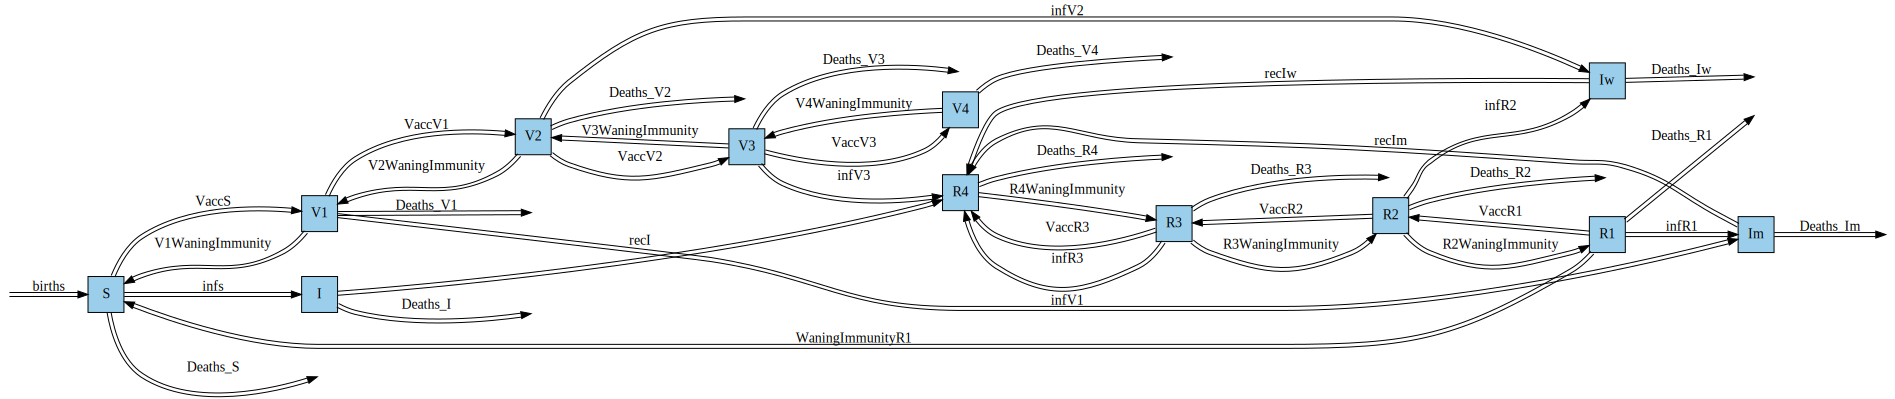

In [17]:
Graph(pertussis_model,type="SF")

# Solve ODEs

In [18]:
# define values of constant parameters
p = LVector(
    β=0.184, rBirth=30*0.32/365.0, rDeath=30*0.32/365.0, ϵ=30.0 * 0.01 / 365.0, 
    vacc=1.0/4.0, α=30.0 * 1.0 / (5 * 365), τ=30.0 * 1.0 / (2 * 365), γ=30.0 * 1.0 / 21
)
# define initial values for stocks
u0 = LVector(
    S=863544.0, I=10.0, Im=0.0, Iw=0.0,
    R1=0.0, R2=0.0, R3=0.0, R4=0.0,
    V1=0.0, V2=0.0, V3=0.0, V4=0.0
)

12-element LArray{Float64, 1, Vector{Float64}, (:S, :I, :Im, :Iw, :R1, :R2, :R3, :R4, :V1, :V2, :V3, :V4)}:
  :S => 863544.0
  :I => 10.0
 :Im => 0.0
 :Iw => 0.0
 :R1 => 0.0
 :R2 => 0.0
 :R3 => 0.0
 :R4 => 0.0
 :V1 => 0.0
 :V2 => 0.0
 :V3 => 0.0
 :V4 => 0.0

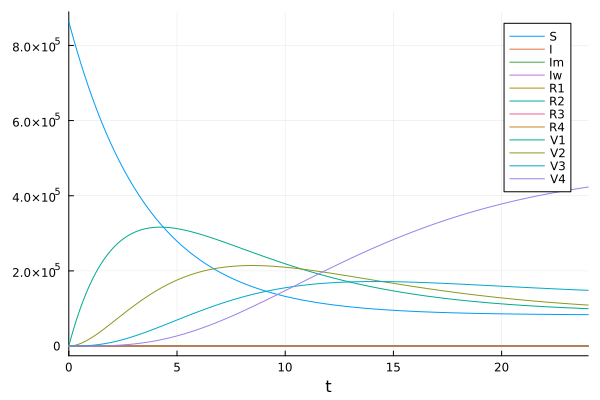

In [19]:
# results are tested the same as the Anylogic model
prob_pertussis = ODEProblem(vectorfield(pertussis_model),u0,(0.0,24.0),p);
sol = solve(prob_pertussis,Tsit5(),abstol=1e-8);
plot(sol)

In [20]:
# to have the figures plotted fix to the wider of the cells
HTML("""
<style>
.output_svg div{
  width: 100% !important;
  height: 100% !important;
}
</style>
""")


HTML{String}("<style>\n.output_svg div{\n  width: 100% !important;\n  height: 100% !important;\n}\n</style>\n")